# Tutorial: Make way for MOANA (Multi Ordination ANAlysis, that is)

## Interacting with multiple phytoplankton groups simultaneously

MOANA is the first phytoplankton community composition algorithm to be released by PACE. This product returns near-surface concentrations (cells mL-1) of three different picophytoplankton (i.e., phytoplankton <2 μm in size): Prochlorococcus, Synechococcus, and autotrophic picoeukaryotes (Figure 15). The algorithm uses empirical relationships between measured cell concentrations, in situ hyperspectral remote sensing reflectances, and sea surface temperatures. Details of this algorithm can be found in [Lange et al. (2020)](https://doi.org/10.1364/OE.398127).

Picophytoplankton are composed of the cyanobacteria Prochlorococcus (∼0.8 µm) and Synechococcus (∼1 µm), as well as picoeukaryotes, which combined are responsible for 50 to 90% of all primary production in open ocean ecosystems and contribute up to 30% of carbon export in these regions. Geographically, Prochlorococcus tends to inhabit warmer and mostly oligotrophic waters surrounded by Synechococcus patches along frontal boundaries. These fronts often reside at boundaries where phytoplankton communities start to transition to higher concentrations of larger eukaryotic cells, such as picoeukaryotes and nanoeukaryotic flagellates. Thus, identification of Prochlorococcus and Synechococcus distributions may be useful in identifying trophic boundaries in oceanic ecosystems, in addition to providing insight into productivity, food web regimes, and carbon export.

Note, for now, the MOANA product is only avaialble for the Atlantic Ocean.

By the end of this tutorial, you will have:

> 1. Created pretty maps of the three phytoplankton classes in MOANA
> 2. Plotted how all three of these phytoplankton classes change in relation to latitude
> 3. Plotted how all three of these phytoplankton classes change over the course of 1 year
> 4. Created a ternary plot and map that shows where each phytoplankton class dominates

## *Are you ready?*

## Lock and load the data

We're going to do something slightly different here, and pull from ERDDAP instead of NASA Earth Access.

In [2]:
# ---- Load Libraries ----
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr
import cartopy
import cartopy.crs as ccrs
import cartopy.feature as cfeature

# ---- Load Data ----
url = "https://cwcgom.aoml.noaa.gov/erddap/griddap/noaa_aoml_a113_ab04_933f"
dataset = xr.open_dataset(url)

dataset = dataset.sel(time="2024-09-25T00:00:00.000000000")

# Assign core variables
latitude = dataset["latitude"]
longitude = dataset["longitude"]
syn_da = dataset["syncoccus_moana"]
pico_da = dataset["picoeuk_moana"]
pro_da = dataset["prococcus_moana"]

ERDDAP is serving up 8-day averages... but I want a monthly composite! No worries - let's pull the date range we need and average them together. How about September? Fall equinox is a good time to have the poles somewhat equally represented. 

## It's map time again

We've got three different phytoplankton classes in this MOANA data set. Let's create some pretty maps and get a sense of their relative distributions.

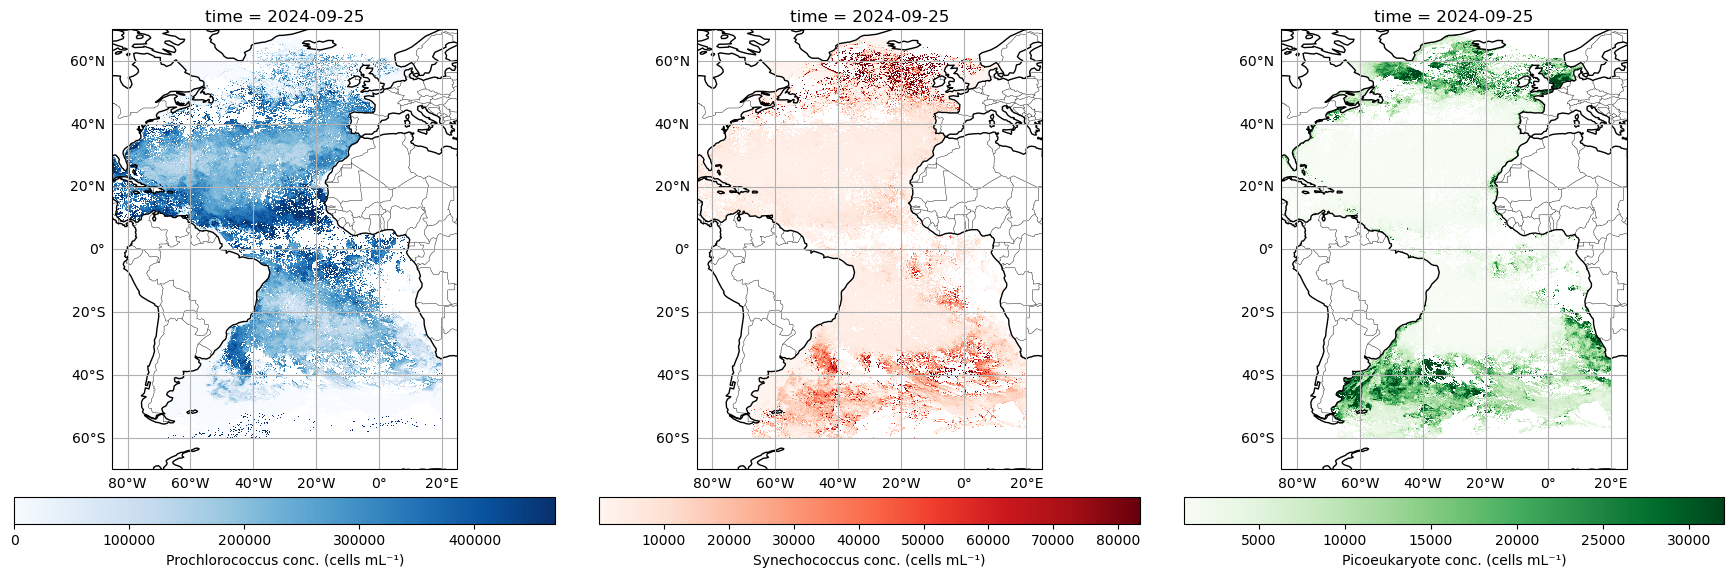

In [3]:
# Define colormaps
custom_cmaps = {
    "Prochlorococcus": plt.cm.Blues,
    "Synechococcus": plt.cm.Reds,
    "Picoeukaryotes": plt.cm.Greens
}

# Label text for colorbars
colorbar_labels = {
    "Prochlorococcus": "Prochlorococcus conc. (cells mL⁻¹)",
    "Synechococcus": "Synechococcus conc. (cells mL⁻¹)",
    "Picoeukaryotes": "Picoeukaryote conc. (cells mL⁻¹)"
}

# Set up figure and axes
fig, axs = plt.subplots(1, 3, figsize=(18, 6),
                        subplot_kw={'projection': ccrs.PlateCarree()})

phyto_list = [
    ("Prochlorococcus", pro_da, axs[0]),
    ("Synechococcus", syn_da, axs[1]),
    ("Picoeukaryotes", pico_da, axs[2])
]

for title, data, ax in phyto_list:
    ax.set_title(title)
    ax.coastlines()
    ax.add_feature(cfeature.BORDERS, linewidth=0.3)
    gl = ax.gridlines(draw_labels=True)
    gl.right_labels = gl.top_labels = False

    # Plot with custom ternary-style colormap and auto robust scaling
    cmap = custom_cmaps[title]
    img = data.plot(
        ax=ax,
        x="longitude", y="latitude",
        cmap=cmap,
        robust=True,
        add_colorbar=False
    )

    # Add custom colorbar label
    cbar = plt.colorbar(img, ax=ax, orientation='horizontal', pad=0.05, shrink=0.9)
    cbar.set_label(colorbar_labels[title])

plt.tight_layout()
plt.show()

Looking good! Here you can see that little ole Prochlorococcus really runs amok in the offshore waters, where both Synechococcus and Picoeukaryotes tend to dominate at higher latitudes, and Picoeukaryotes assert their dominance in along the coastal margins... you know, to the degree that a free-floating cell can "assert" anything.

## Let's get a bit more quantitative

Let's get a little better sense of how these phytoplakton classes are geographically distributed. What we're going to do next is plot how all three of these phytoplankton classes change in relation to latitude. To do this, we'll be taking "slices" of data and averaging them. Conceptually, think of a horizontal line across 50 degrees North - we'll extract all that data, take an average, and then move on to the pixel below (e.g. 49.98 degrees North) and do the same until we hit 50 degrees South. Doing this for each phytoplankton class, we can now distill this information into something that can be put onto a line plot. 

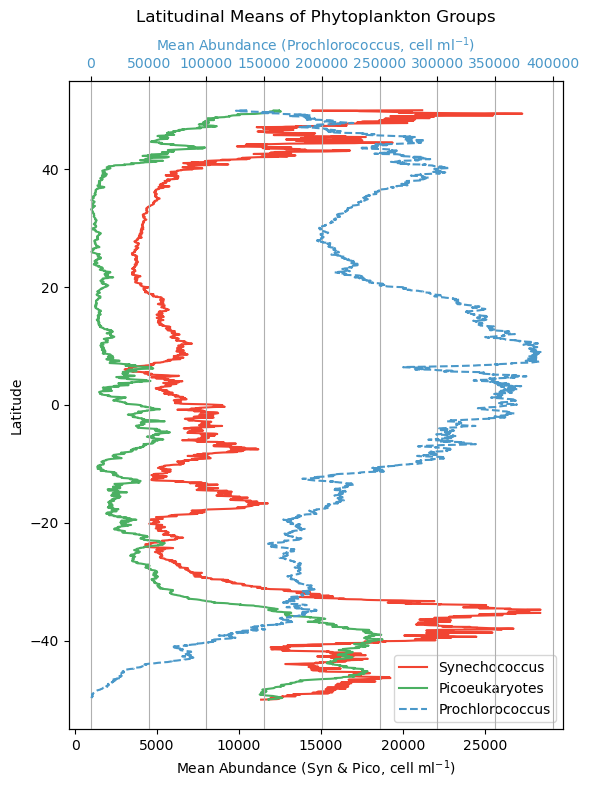

In [8]:
syn = dataset["syncoccus_moana"].sel(latitude = slice(50, -50)).mean(dim=["longitude"])
pro = dataset["prococcus_moana"].sel(latitude = slice(50, -50)).mean(dim=["longitude"])
pico = dataset["picoeuk_moana"].sel(latitude = slice(50, -50)).mean(dim=["longitude"])

custom_colors = {
    "Prochlorococcus": plt.cm.Blues(0.6),
    "Synechococcus": plt.cm.Reds(0.6),
    "Picoeukaryotes": plt.cm.Greens(0.6)
}

fig, ax1 = plt.subplots(figsize=(6, 8))  # Taller figure for vertical layout

# Primary axis: Syn and Pico
ax1.plot(syn, syn["latitude"], label="Synechococcus", color=custom_colors["Synechococcus"])
ax1.plot(pico, pico["latitude"], label="Picoeukaryotes", color=custom_colors["Picoeukaryotes"])
ax1.set_ylabel("Latitude")
ax1.set_xlabel("Mean Abundance (Syn & Pico, cell ml$^{-1}$)", color="black")
ax1.tick_params(axis='x', labelcolor="black")

# Secondary axis: Prochlorococcus
ax2 = ax1.twiny()
ax2.plot(pro, pro["latitude"], label="Prochlorococcus", color=custom_colors["Prochlorococcus"], linestyle="--")
ax2.set_xlabel("Mean Abundance (Prochlorococcus, cell ml$^{-1}$)", color=custom_colors["Prochlorococcus"])
ax2.tick_params(axis='x', labelcolor=custom_colors["Prochlorococcus"])

# Combine legends
lines_1, labels_1 = ax1.get_legend_handles_labels()
lines_2, labels_2 = ax2.get_legend_handles_labels()
ax1.legend(lines_1 + lines_2, labels_1 + labels_2, loc="lower right")

plt.title("Latitudinal Means of Phytoplankton Groups", pad=10)
plt.grid(True)
plt.tight_layout()
plt.show()

Note that *Prochlorococcus* is on a separate axis here because the cells are so abundant. That doesn't necessarily mean they represent a larger amount of biomass across the board though. *Prochlorococcus* are teeny tiny little cyanobacteria cells, and *Synechococcus* and picoeukaryotes are larger, so in the latter case, fewer cells can represent more overall biomass. We make this distinction here becuase when we later consider which phytoplankton class is "dominant" in an area, it is relative to their respective range of concentrations, not absolute cell counts.

## The times, they are a changin'

For this exercise, we'll download one year's worth of PACE data to see how things are evolving over time. Using this time series, we're going to use the "slice" function again, but this time we'll extract a 3 degree x 3 degree box in the south Atlantic ocean. It can be smaller/larger, or located elsewhere if you like, but either way, we're going to average the data within that box for each individual time step.

Next, we'll plot how all three of these phytoplankton classes change over the course of ~1 year, allowing you to see the cycles of growth and decay relative to one another. It is useful to add this context because not all chlorophyll-a is equivalent, e.g., a bloom of *Prochlorococcus* may represent a different amount of trophic energy potential relative to blooms of other phytoplankton classes, or it may havce come about from a different oceanographic process. 

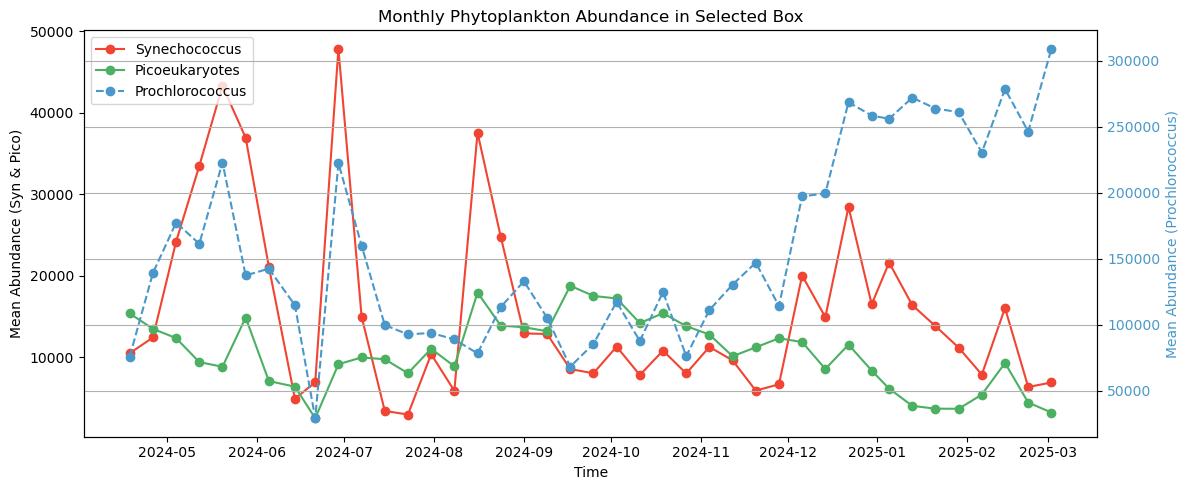

In [11]:
# ---- Load Data ----
url = "https://cwcgom.aoml.noaa.gov/erddap/griddap/noaa_aoml_a113_ab04_933f"
dataset = xr.open_dataset(url)
da=dataset.sel(latitude=slice(-39,-42), longitude=slice(-54,-51))

# Assign core variables
latitude_ts = da["latitude"]
longitude_ts = da["longitude"]
syn_ts = da["syncoccus_moana"].mean(dim=["latitude", "longitude"])
pico_ts = da["picoeuk_moana"].mean(dim=["latitude", "longitude"])
pro_ts = da["prococcus_moana"].mean(dim=["latitude", "longitude"])

# Create the figure and axis
fig, ax1 = plt.subplots(figsize=(12, 5))

# Plot syn and pico on the left y-axis
ax1.plot(syn_ts["time"], syn_ts, 'o-', label="Synechococcus", color=custom_colors["Synechococcus"])
ax1.plot(pico_ts["time"], pico_ts, 'o-', label="Picoeukaryotes", color=custom_colors["Picoeukaryotes"])
ax1.set_xlabel("Time")
ax1.set_ylabel("Mean Abundance (Syn & Pico)", color="black")
ax1.tick_params(axis='y', labelcolor="black")

# Create a secondary y-axis for prococcus_moana
ax2 = ax1.twinx()
ax2.plot(pro_ts["time"], pro_ts, 'o--', label="Prochlorococcus", color=custom_colors["Prochlorococcus"])
ax2.set_ylabel("Mean Abundance (Prochlorococcus)", color=custom_colors["Prochlorococcus"])
ax2.tick_params(axis='y', labelcolor=custom_colors["Prochlorococcus"])

# Combine all legends
lines_1, labels_1 = ax1.get_legend_handles_labels()
lines_2, labels_2 = ax2.get_legend_handles_labels()
ax1.legend(lines_1 + lines_2, labels_1 + labels_2, loc="upper left")

# Add title and grid
plt.title("Monthly Phytoplankton Abundance in Selected Box")
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

## Bringing it all together

A central theme of working with PACE data revolves around wrangling multiple dimensions of data into something you can conceptualize. Viewing three separate maps makes it a bit difficult to see the interactions between the different phytoplankton classes. This is important - we want to know where these boundaries are colliding, because this indicates that something is changing with the underlying oceanography. 

Let's try something a little different here. Instead of making three separate plots, let's stack them all and make a false "true color" image by substituting the usual red, green, and blue radiance channels with *Synechococcus* (red), Picoeukaryotes (green), and *Proclorococcus* (blue). Can it be done? 

Yes, but with a tiny bit of nuance here. We talked earlier about how higher cell counts does not unequivocally mean that this is a "dominant" class. We can do something called histogram stretching, which is a little trick some folks use to make their true color images pop a little more. Basically, for each phytoplankton class, let's take all the data between the 2% and 98% percentile range, and normalize those data to the respective median. This ensure all phytoplankton classes are now on a level playing field when we stack them up. Higher or lower values no longer represent absolute cell counts, they now represent higher or lower weights relative to their central tendency. The same trick is often done for making "true color" images to make them pop a little more. Let's give it a try: 

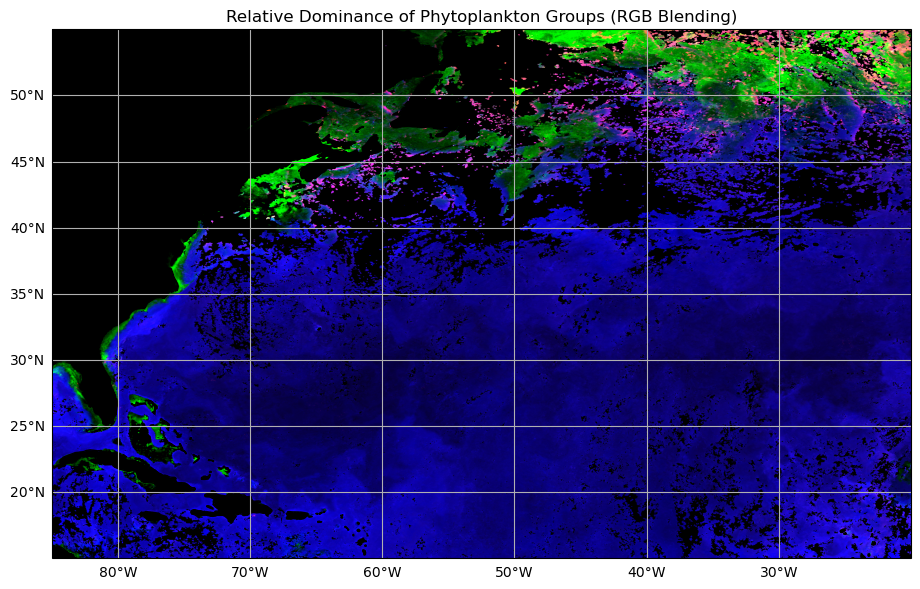

<Figure size 640x480 with 0 Axes>

In [5]:
import cartopy.crs as ccrs
import cartopy.feature as cfeature

def robust_normalize(arr):
    vmin, vmax = np.nanpercentile(arr, [2, 98])
    return np.clip((arr - vmin) / (vmax - vmin), 0, 1)

pro_norm = robust_normalize(pro_da.values)
syn_norm = robust_normalize(syn_da.values)
pico_norm = robust_normalize(pico_da.values)

# Stack into an RGB image (shape: lat x lon x 3)
rgb_image = np.stack([syn_norm, pico_norm, pro_norm], axis=-1)  # R=Syn, G=Pico, B=Pro

# Set pixels with all zeros (e.g., NaNs) to black
rgb_image[np.isnan(rgb_image)] = 0
rgb_image = np.flipud(rgb_image)

# Plot the RGB image
fig, ax = plt.subplots(figsize=(10, 6), subplot_kw={'projection': ccrs.PlateCarree()})
ax.set_title("Relative Dominance of Phytoplankton Groups (RGB Blending)")
ax.coastlines()
ax.add_feature(cfeature.BORDERS, linewidth=0.3)
gl = ax.gridlines(draw_labels=True)
gl.right_labels = gl.top_labels = False

# Use imshow with full extent
extent = [pro_da.longitude.min(), pro_da.longitude.max(), pro_da.latitude.min(), pro_da.latitude.max()]
ax.imshow(rgb_image, origin='lower', extent=extent, transform=ccrs.PlateCarree())

# Show only north of the equator
ax.set_extent([pro_da.longitude.min(), pro_da.longitude.max(), 0, pro_da.latitude.max()], crs=ccrs.PlateCarree())
ax.set_extent([pro_da.longitude.min(), -20, 15, 55], crs=ccrs.PlateCarree())

plt.tight_layout()
plt.show()
plt.tight_layout()
plt.show()

Now you can really see where each phytoplankton class domianates, and through the gradational mixing of colors, we can see where, and to what degree they overlap. Neat, right?

## Just a tiny bit more context, please

We still could use a bit of help contextualizing the above image, so let's just make a little legend for it. Since we're in tri-color space, let's use the very useful, and in my opinion, underutilized ternary plot. These are fun little plots that show the relative contribution of three variables relative to one another. It helps us determine how to interpret the purple, teal, pink, and orange areas you see on the map.  

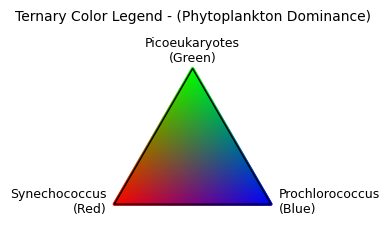

In [6]:
from matplotlib.patches import Polygon

# Define triangle vertices (RGB space: R=Syn, G=Pico, B=Pro)
triangle = np.array([
    [0.5, np.sqrt(3)/2],  # top = Pico (Green)
    [0, 0],               # bottom left = Syn (Red)
    [1, 0]                # bottom right = Pro (Blue)
])

# Create barycentric coordinates for triangle
res = 150
bary_coords = np.array([
    [i / res, j / res, 1 - i / res - j / res]
    for i in range(res + 1)
    for j in range(res + 1 - i)
])
rgb_vals = bary_coords[:, [1, 0, 2]]  # R=Syn, G=Pico, B=Pro
rgb_vals = np.clip(rgb_vals, 0, 1)

# Convert to triangle (x, y) coordinates
xy_coords = (bary_coords[:, 0:1] * triangle[0] +
             bary_coords[:, 1:2] * triangle[1] +
             bary_coords[:, 2:3] * triangle[2])

# Plot the ternary color key
fig, ax = plt.subplots(figsize=(4, 4))
ax.set_aspect('equal')
ax.axis('off')

ax.scatter(xy_coords[:, 0], xy_coords[:, 1], c=rgb_vals, s=2)
ax.add_patch(Polygon(triangle, closed=True, edgecolor='black', fill=False))

# Labels
ax.text(0.5, np.sqrt(3)/2 + 0.05, "Picoeukaryotes\n(Green)", ha='center', fontsize=9)
ax.text(-0.05, -0.05, "Synechococcus\n(Red)", ha='right', fontsize=9)
ax.text(1.05, -0.05, "Prochlorococcus\n(Blue)", ha='left', fontsize=9)

plt.title("Ternary Color Legend - (Phytoplankton Dominance)", fontsize=10, pad=30)
plt.tight_layout()
plt.show()

There you have it! PACE's first phytoplankton class algorithm. Note, even if these specific critters are not of particular interest to you, they are excellent indicators of underlying oceanographic processes (MOANA uses SST as an input as well). If you are a highly migratory species traversing the open seas, these boundaries may very well be influencial. 